In [1]:
import warnings
warnings.filterwarnings("ignore")
# import tensorflow
import numpy as np 
import pandas as pd 
import random 
import sys
import time 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from collections import deque 
from collections import namedtuple, defaultdict
import gym 
import copy
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
env = gym.make("LunarLander-v2")

In [3]:
print('Action Space size: {}, State Space size: {}'.format(env.action_space.n, env.observation_space.shape[0]))

Action Space size: 4, State Space size: 8


### Set up the Device

In [4]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


### Define the Network for (Deep Q-Network)

In [5]:
class DQNet(nn.Module):
    
    def __init__(self, env, seed): 
        
        super(DQNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.num_state = env.observation_space.shape[0]
        self.num_action = env.action_space.n
        
        self.layer_1 = nn.Linear(self.num_state, 32)
        self.layer_2 = nn.Linear(32, 64)
        self.layer_3 = nn.Linear(64, self.num_action)
        
        
    def forward(self, x):
        x = torch.FloatTensor(x).to(device)
        
        x = self.layer_1(x)
        x = F.relu(x)
        
        x = self.layer_2(x)
        x = F.relu(x)
        
        x =  self.layer_3(x)
        return x
    

In [6]:
class ReplayBuffer():
    '''
    This class is for the experience replay where we store the agent's experiences at each time step in a data set. 
    polled over many episodes into a replay memory. 
    '''
    def __init__(self, buffer_size, batch_size, seed):
        
        '''
        param: buffer_size : Size for memory initialization
        param: batch_size : batch size 
        param: seed : random seed value to be set. 

        '''
        
        assert isinstance(buffer_size, int)
        assert isinstance(batch_size, int)
        assert isinstance(seed, int)
        
        self.seed = random.seed(seed)
        self.buffer_size = buffer_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size 
        self.experience = namedtuple("Experience", field_names = ['state', 'action', 'reward', 'next_state', 'done'])
        
    
    def buffer_add(self, state, action, reward, next_state, done):
        
        '''  Add experience to the memory and experience tuple.  '''
        
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
        
    def buffer_sample(self): 
        '''
        randomly sample experience from the memory and return it
        '''
        
        exp = random.sample(self.memory, k = self.batch_size)
        
        # convert the tuple into seperate stacks for each observation. 
        state  = torch.from_numpy(np.vstack( [e.state  for e in exp] )).float().to(device)
        action = torch.from_numpy(np.vstack( [e.action for e in exp] )).long().to(device)
        reward = torch.from_numpy(np.vstack( [e.reward for e in exp] )).float().to(device)
        next_s = torch.from_numpy(np.vstack( [e.next_state for e in exp] )).float().to(device)
        done   = torch.from_numpy(np.vstack( [int(e.done)  for e in exp] )).float().to(device)
        
        return (state, action, reward, next_s, done)

In [7]:
class Agent: 
    
    def __init__(self, env, lr,  seed):
        
        self.num_state = env.observation_space.shape[0]
        self.num_action = env.action_space.n
        
        self.seed = random.seed(seed)
        
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.q_net = DQNet(env,seed).to(device)
        self.q_net_target = DQNet(env,seed).to(device)
        
        self.optimizer = optim.Adam(self.q_net.parameters(), lr = lr)
        
        self.time_step = 0
        
    def update_buffer(self,  state, action, reward, new_state, done):
        '''
        add the experience to the replay buffer memory. 
        '''
        # add the current experience to the replay buffer memory 
        self.buffer.buffer_add(state, action, reward, new_state, done)
        self.time_step += 1 
        
        if self.time_step % UPDATE_EVERY == 0: 
            if len(self.buffer.memory) > BATCH_SIZE:
                sample_experience = self.buffer.buffer_sample()
                self.train(sample_experience)
    
    def get_action(self,  state, epsilon = 0.0):
        
        ''' get action for the given state, will use e-greedy policy method to select our action'''
        
        # Choose probability epsilon, select random action 
        if random.random() < epsilon: 
            action = np.random.randint(self.num_action)
            return action
        
        # else select the maz of Q function. 
        else: 
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.q_net.eval()
            with torch.no_grad():
                action = self.q_net(state)
            self.q_net.train()    
            action = np.argmax(action.cpu().data.numpy())
            return action 
    
    def update_target_networks(self, target_model, source_model, tau=1e-3):
        
        ''' Function to update the target network using the current network parameters and Tau '''
        
        for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
            target_param.data.copy_(target_param.data*(1.0 - tau) + source_param.data*tau)  
        
    
    def train(self, experience):
        
        '''
        Train the DQ Network  
        '''
           
        state, action, reward, next_state, done = experience # experience from Replay memory 
       
        # get the action for current states
        self.q_net.train()
        current_Q = self.q_net(state).gather(dim = 1, index = action)
        
        # get the next action for next states 
        self.q_net.eval()
        with torch.no_grad():
            tar_Q = self.q_net_target(next_state) #.detach()
        max_tar_Q = tar_Q.data.max(1)[0].unsqueeze(1)
        # execute the action in emulator and observe reward and image 
        
        Q_target = reward + (GAMMA * max_tar_Q * (1 - done))
        
        # Calculare loss and update parameters for q_net 
        self.optimizer.zero_grad()
        loss = F.mse_loss(current_Q, Q_target)
        loss.backward()
        self.optimizer.step()

        # update target network parameters 
        self.update_target_networks(self.q_net_target, self.q_net)


In [8]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64 
GAMMA = 0.99
UPDATE_EVERY = 4

epsilon = 1.0      
delta_epsilon = 0.999    
min_epsilon = 0.01      

num_episodes = 2500
num_steps = 1000 

In [9]:
env = gym.make("LunarLander-v2")
agent = Agent(env, lr = 5e-4,  seed = 0) 

time_start = time.time()

score_all = []
scores_100 = deque(maxlen = 100)
reward_track = []

for epoch in range(1, num_episodes + 1):
    
    # get current state
    state = env.reset()
    score = 0 
    
    for i in range(num_steps): 
        
        action = agent.get_action(state, epsilon)
        next_state, reward, done, info = env.step(action)
        
        # update buffer/store in buffer
        agent.update_buffer(state, action, reward, next_state, done)
        
        # update state
        state = next_state
        
        score += reward # add reward to the score
        
        if done:
            break 
            
    score_all.append(score) 
    scores_100.append(score)
    
    epsilon = max(epsilon * delta_epsilon, min_epsilon)
    

    if epoch % 100 == 0:
        avg_reward = np.mean(scores_100)
        reward_track.append(avg_reward)
        print('Epochs {}/{}, Average score = {:.4f}'.format(epoch,num_episodes, avg_reward))
        if avg_reward >= 200:  # 200 is the maximum score for the environment to be solved. 
            print('Environment solved in {} episodes and average score = {:.4f}'.format(epoch,avg_reward))
            break
            
time_end = time.time()

print('Program took {} minutes to run'.format((time_end - time_start)/60))

Epochs 100/2500, Average score = -189.4112
Epochs 200/2500, Average score = -149.4873
Epochs 300/2500, Average score = -147.0176
Epochs 400/2500, Average score = -119.6287
Epochs 500/2500, Average score = -85.8740
Epochs 600/2500, Average score = -79.5091
Epochs 700/2500, Average score = -56.8147
Epochs 800/2500, Average score = -27.5874
Epochs 900/2500, Average score = -0.7512
Epochs 1000/2500, Average score = 38.7636
Epochs 1100/2500, Average score = 55.6724
Epochs 1200/2500, Average score = 68.8260
Epochs 1300/2500, Average score = 76.4143
Epochs 1400/2500, Average score = 94.5837
Epochs 1500/2500, Average score = 125.1646
Epochs 1600/2500, Average score = 149.6608
Epochs 1700/2500, Average score = 199.2266
Epochs 1800/2500, Average score = 190.7638
Epochs 1900/2500, Average score = 187.9447
Epochs 2000/2500, Average score = 219.6065
Environment solved in 2000 episodes and average score = 219.6065
Program took 16.107703133424124 minutes to run


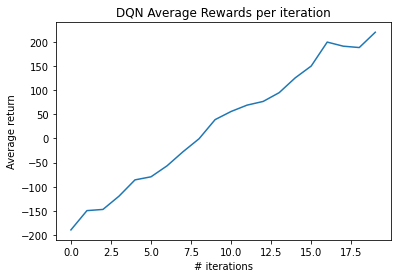

In [10]:
# plot for the return after each policy update.
plt.figure()
plt.plot(reward_track)
plt.xlabel('# iterations')
plt.ylabel('Average return')
plt.title('DQN Average Rewards per iteration')
plt.show()